In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d cosmos98/twitter-and-reddit-sentimental-analysis-dataset

 70% 7.00M/10.0M [00:00<00:00, 13.8MB/s]
100% 10.0M/10.0M [00:00<00:00, 12.7MB/s]


In [ ]:
!kaggle datasets download -d mortena/fb-sentiment

  0% 0.00/48.1k [00:00<?, ?B/s]
100% 48.1k/48.1k [00:00<00:00, 2.03MB/s]


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/fb-sentiment.zip','r')
zip_ref=zipfile.ZipFile('/content/twitter-and-reddit-sentimental-analysis-dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df_fb = pd.read_csv('/content/fb-sentiment.zip')
df_twitter = pd.read_csv('/content/Twitter_Data.csv')

In [ ]:
df_fb.head()

,Unnamed: 0,FBPost,Label
0,0,Drug Runners and a U.S. Senator have somethin...,O
1,1,"Heres a single, to add, to Kindle. Just read t...",O
2,2,If you tire of Non-Fiction.. Check out http://...,O
3,3,Ghost of Round Island is supposedly nonfiction.,O
4,4,Why is Barnes and Nobles version of the Kindle...,N


In [ ]:
df_twitter.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
new_df_fb=df_fb.drop(columns='Unnamed: 0',axis=1)
new_df_fb

,FBPost,Label
0,Drug Runners and a U.S. Senator have somethin...,O
1,"Heres a single, to add, to Kindle. Just read t...",O
2,If you tire of Non-Fiction.. Check out http://...,O
3,Ghost of Round Island is supposedly nonfiction.,O
4,Why is Barnes and Nobles version of the Kindle...,N
...,...,...
995,I liked it. Its youth oriented and I think th...,P
996,"I think the point of the commercial is that, e...",P
997,Kindle 3 is such a great product. I could not ...,P
998,develop a way to share books! that is a big d...,N


In [ ]:
new_df_fb.rename(columns={'FBPost':'comment','Label':'category'}, inplace=True)
df_twitter.rename(columns={'clean_text':'comment'}, inplace=True)

In [ ]:
new_df_fb['category']=new_df_fb['category'].map({'N':-1.0,'O':0.0,'P':1.0})
new_df_fb

,comment,category
0,Drug Runners and a U.S. Senator have somethin...,0.0
1,"Heres a single, to add, to Kindle. Just read t...",0.0
2,If you tire of Non-Fiction.. Check out http://...,0.0
3,Ghost of Round Island is supposedly nonfiction.,0.0
4,Why is Barnes and Nobles version of the Kindle...,-1.0
...,...,...
995,I liked it. Its youth oriented and I think th...,1.0
996,"I think the point of the commercial is that, e...",1.0
997,Kindle 3 is such a great product. I could not ...,1.0
998,develop a way to share books! that is a big d...,-1.0


In [ ]:
def cleanText(string):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    cleanedText = ' '.join(''.join([i for i in string if not i.isdigit()]).split())
    
    for i in punc:
        cleanedText = cleanedText.replace(i, '')
        
    a = [i for i in cleanedText if i.isalpha() or i == ' ']
            
    final_text = ' '.join(''.join(a).split())
    return final_text

In [ ]:
new_df_fb = new_df_fb.dropna(how='any')
df_twitter = df_twitter.dropna(how='any')

In [ ]:
new_df_fb.category = new_df_fb.category.apply(lambda x: int(x))
df_twitter.category = df_twitter.category.apply(lambda x: int(x))

new_df_fb.comment = new_df_fb.comment.apply(cleanText)
df_twitter.comment = df_twitter.comment.apply(cleanText)

In [ ]:
new_df_fb.drop_duplicates(subset='comment', keep=False, inplace=True)
df_twitter.drop_duplicates(subset='comment', keep=False, inplace=True)

In [ ]:
# Concat reddit data and twiter data
concat_df = pd.concat([new_df_fb, df_twitter], ignore_index=True)

In [ ]:
counts = [len(new_df_fb), len(df_twitter), len(concat_df)]
labels = ['Facebook', 'Twitter', 'Total']
colors = ['#ff4500', '#1DA1F2', '#50C878']

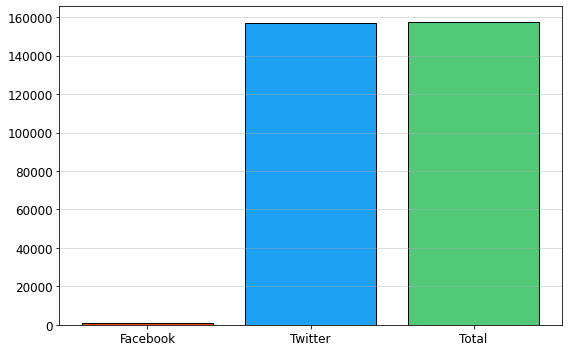

In [ ]:
plt.figure(figsize=(8,5))

plt.bar(labels, counts, color=colors, edgecolor='black')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

In [ ]:
negative_count = [len(new_df_fb[new_df_fb.category == -1]),
                 len(df_twitter[df_twitter.category == -1]),
                 len(concat_df[concat_df.category == -1])]

neutral_count = [len(new_df_fb[new_df_fb.category == 0]),
                 len(df_twitter[df_twitter.category == 0]),
                 len(concat_df[concat_df.category == 0])]

positive_count = [len(new_df_fb[new_df_fb.category == 1]),
                 len(df_twitter[df_twitter.category == 1]),
                 len(concat_df[concat_df.category == 1])]

x = ['Facebook', 'Twitter', 'Total']
x_indexes = np.arange(len(x))
width = 0.25

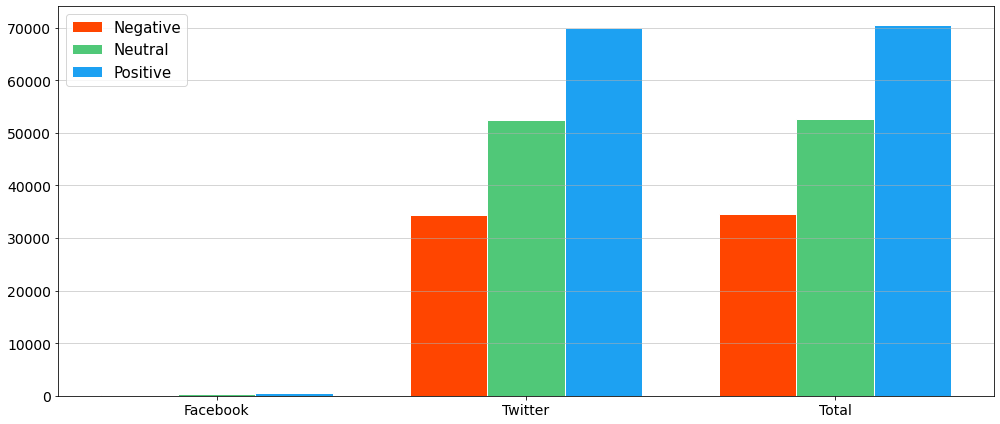

In [ ]:
plt.figure(figsize=(14,6))

plt.bar(x_indexes - width, negative_count, width=width, label='Negative', edgecolor='white', color='#ff4500')
plt.bar(x_indexes, neutral_count, width=width, label='Neutral', edgecolor='white', color='#50C878')
plt.bar(x_indexes + width, positive_count, width=width, label='Positive', edgecolor='white', color='#1DA1F2')

plt.yticks(fontsize=14)
plt.xticks(ticks=x_indexes, labels=x, fontsize=14)

plt.legend(prop={'size':15})
plt.grid(axis='y', alpha=0.65)
plt.tight_layout()

In [ ]:
negative_avg = int(sum([len(i) for i in concat_df[concat_df.category == -1].comment]) / len(concat_df[concat_df.category == 1]))
neutral_avg = int(sum([len(i) for i in concat_df[concat_df.category == 0].comment]) / len(concat_df[concat_df.category == 0]))
positive_avg = int(sum([len(i) for i in concat_df[concat_df.category == 1].comment]) / len(concat_df[concat_df.category == 1]))

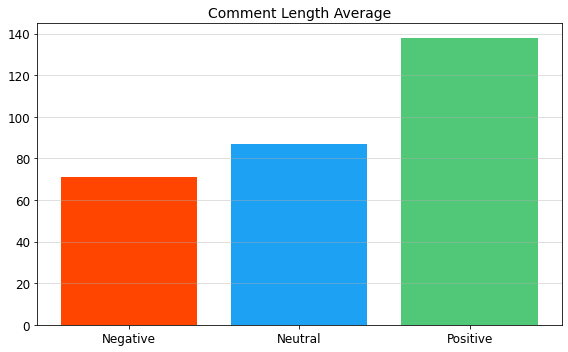

In [ ]:
plt.figure(figsize=(8,5))

plt.bar(['Negative', 'Neutral', 'Positive'], [negative_avg, neutral_avg, positive_avg], color=colors)

plt.title('Comment Length Average', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(axis='y', alpha=0.5)
plt.tight_layout()

In [ ]:
negative_words = ''
neutral_words = ''
positive_words = ''

stopwords = set(STOPWORDS)

for comment, category in zip(concat_df.comment, concat_df.category):
    tokens = comment.split()
    
    for word in tokens:
        if category == -1:
            negative_words += word + ' '
        elif category == 0:
            neutral_words += word + ' '
        else:
            positive_words += word + ' '

In [ ]:
negative_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(negative_words)

neutral_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(neutral_words)

positive_cloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(positive_words)

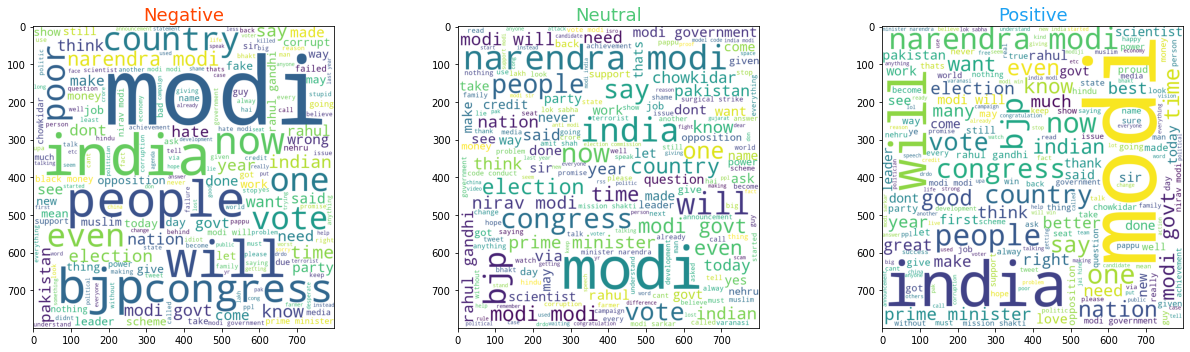

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5), facecolor=None)

ax1.imshow(negative_cloud)
ax1.set_title('Negative', fontsize=18, color='#ff4500')


ax2.imshow(neutral_cloud)
ax2.set_title('Neutral', fontsize=18, color='#50C878')

ax3.imshow(positive_cloud)
ax3.set_title('Positive', fontsize=18, color='#1DA1F2')

plt.tight_layout()

In [ ]:
class Data:
    def __init__(self, df):
        self.df = df
        
    def fixData(self):
        dataframe = self.df
        lowest_len = min([i for i in dataframe.category.value_counts()])
        
        # Create the final data frame
        final_df = pd.concat([dataframe[dataframe.category == -1][:lowest_len],
                             dataframe[dataframe.category == 0][:lowest_len],
                             dataframe[dataframe.category == 1][:lowest_len]])
        
        # To shuffle the rows in the data frame
        final_df = final_df.sample(frac=1).reset_index(drop=True)
        return final_df

In [ ]:
a = Data(concat_df)
fixed_df = a.fixData()
print(f'Before: \n{concat_df.category.value_counts()}\n')
print(f'After: \n{fixed_df.category.value_counts()}')

Before: 
 1    70533
 0    52681
-1    34502
Name: category, dtype: int64

After: 
-1    34502
 0    34502
 1    34502
Name: category, dtype: int64


In [ ]:
count1 = [len(fixed_df[fixed_df.category == -1])]

count2 = [len(fixed_df[fixed_df.category == 0])]

count3 = [len(fixed_df[fixed_df.category == 1])]

x = ['Facebook', 'Twitter', 'Total']
x_index = np.arange(len(x))
width = 0.25

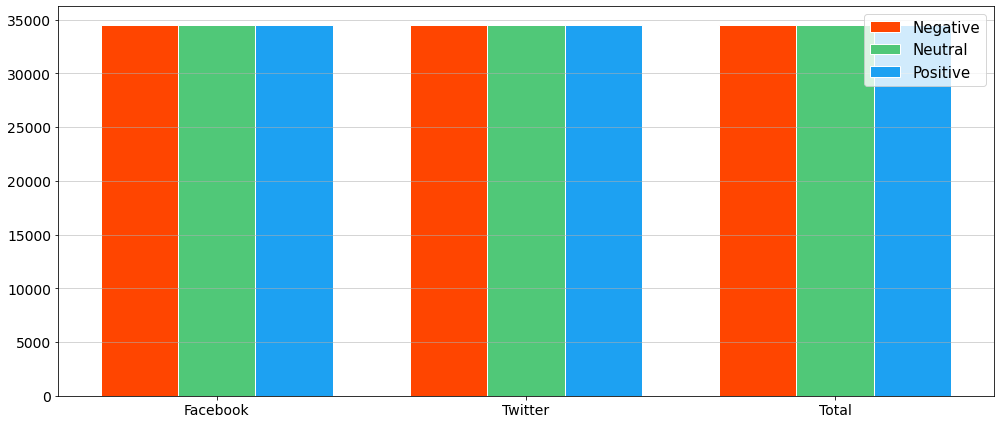

In [ ]:
plt.figure(figsize=(14,6))

plt.bar(x_index - width, count1, width=width, label='Negative', edgecolor='white', color='#ff4500')
plt.bar(x_index, count2, width=width, label='Neutral', edgecolor='white', color='#50C878')
plt.bar(x_index + width, count3, width=width, label='Positive', edgecolor='white', color='#1DA1F2')

plt.yticks(fontsize=14)
plt.xticks(ticks=x_index, labels=x, fontsize=14)

plt.legend(prop={'size':15})
plt.grid(axis='y', alpha=0.65)
plt.tight_layout()

In [ ]:
train_X, test_X, train_y, test_y = train_test_split([i for i in fixed_df.comment], [i for i in fixed_df.category], test_size=0.25, random_state=1)

In [ ]:
vectorizer = TfidfVectorizer()
train_X_vectors = vectorizer.fit_transform(train_X)
test_X_vectors = vectorizer.transform(test_X)

In [ ]:
clf_svm = LinearSVC()
clf_svm.fit(train_X_vectors, train_y)
clf_prediction = clf_svm.predict(test_X_vectors)

print(f'Accuracy: {clf_svm.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, clf_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.9312130463345828
Accuracy: [0.91841004 0.95577155 0.91916778]


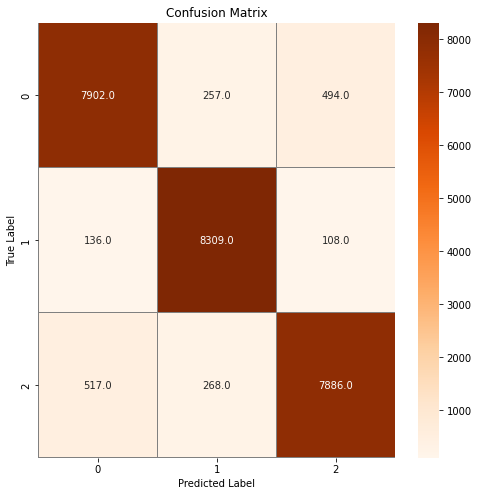

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm=confusion_matrix(test_y, clf_prediction)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(test_y, clf_prediction))

              precision    recall  f1-score   support

          -1       0.92      0.91      0.92      8653
           0       0.94      0.97      0.96      8553
           1       0.93      0.91      0.92      8671

    accuracy                           0.93     25877
   macro avg       0.93      0.93      0.93     25877
weighted avg       0.93      0.93      0.93     25877



In [ ]:
clf_dtc = DecisionTreeClassifier()
clf_dtc.fit(train_X_vectors, train_y)
dtc_prediction = clf_dtc.predict(test_X_vectors)

print(f'Accuracy: {clf_dtc.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, dtc_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.8173667735827183
Accuracy: [0.77668871 0.88694559 0.78686064]


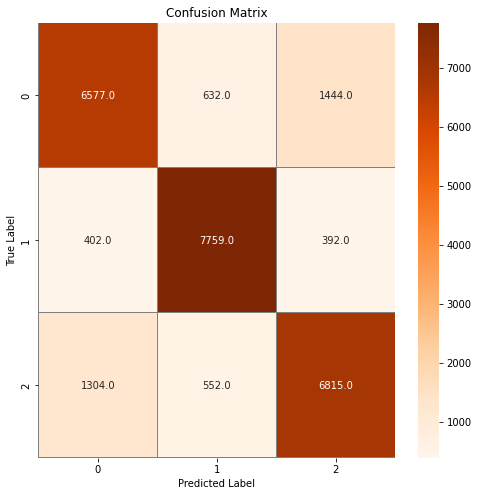

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm=confusion_matrix(test_y, dtc_prediction)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(test_y, dtc_prediction))

              precision    recall  f1-score   support

          -1       0.79      0.76      0.78      8653
           0       0.87      0.91      0.89      8553
           1       0.79      0.79      0.79      8671

    accuracy                           0.82     25877
   macro avg       0.82      0.82      0.82     25877
weighted avg       0.82      0.82      0.82     25877



In [ ]:
from xgboost import XGBClassifier

clf_xgb = XGBClassifier()
clf_xgb.fit(train_X_vectors, train_y)
xgb_prediction = clf_xgb.predict(test_X_vectors)

print(f'Accuracy: {clf_xgb.score(test_X_vectors, test_y)}')
print(f'Accuracy: {f1_score(test_y, xgb_prediction, average=None, labels=[-1, 0, 1])}')

Accuracy: 0.713683966456699
Accuracy: [0.67748184 0.73483485 0.72480752]


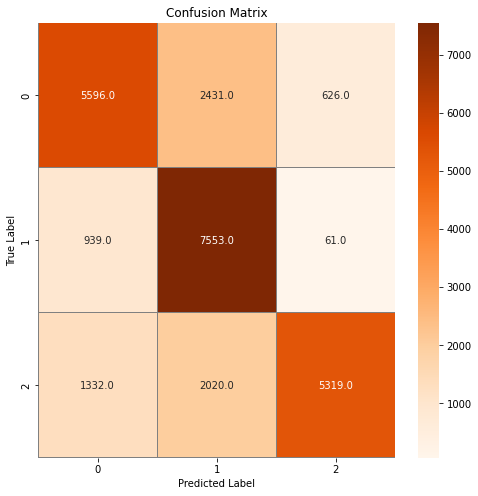

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
cm=confusion_matrix(test_y, xgb_prediction)
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(test_y, xgb_prediction))

              precision    recall  f1-score   support

          -1       0.71      0.65      0.68      8653
           0       0.63      0.88      0.73      8553
           1       0.89      0.61      0.72      8671

    accuracy                           0.71     25877
   macro avg       0.74      0.71      0.71     25877
weighted avg       0.74      0.71      0.71     25877



In [ ]:
max_fatures = 2000
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(fixed_df['comment'].values)
X = tokenizer.texts_to_sequences(fixed_df['comment'].values)
X = pad_sequences(X)
Y = pd.get_dummies(fixed_df['category']).values

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(69349, 160) (69349, 3)
(34157, 160) (34157, 3)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
embed_dim = 200
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 160, 200)          400000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 160, 200)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 3)                 603       
                                                                 
Total params: 721,403
Trainable params: 721,403
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size = 32
hist = model.fit(X_train, Y_train, epochs = 8, batch_size=batch_size, verbose = 1)

Epoch 1/8
2168/2168 [==============================] - 1315s 604ms/step - loss: 0.4578 - accuracy: 0.8353
Epoch 2/8
2168/2168 [==============================] - 1297s 598ms/step - loss: 0.3340 - accuracy: 0.8987
Epoch 3/8
2168/2168 [==============================] - 1286s 593ms/step - loss: 0.3101 - accuracy: 0.9031
Epoch 4/8
2168/2168 [==============================] - 1285s 593ms/step - loss: 0.2918 - accuracy: 0.9070
Epoch 5/8
2168/2168 [==============================] - 1280s 591ms/step - loss: 0.2746 - accuracy: 0.9107
Epoch 6/8
2168/2168 [==============================] - 1277s 589ms/step - loss: 0.2578 - accuracy: 0.9146
Epoch 7/8
2168/2168 [==============================] - 1300s 600ms/step - loss: 0.2444 - accuracy: 0.9179
Epoch 8/8
2168/2168 [==============================] - 1289s 595ms/step - loss: 0.2284 - accuracy: 0.9226


In [ ]:
score,acc = model.evaluate(X_test, Y_test)
print("score: %.2f" % (score))
print("accuracy: %.2f" % (acc))

1068/1068 [==============================] - 69s 64ms/step - loss: 0.3732 - accuracy: 0.8961
score: 0.37
accuracy: 0.90


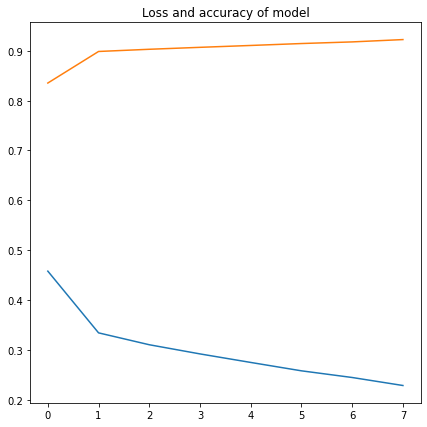

In [ ]:
history = pd.DataFrame(hist.history)
plt.figure(figsize=(7,7));
plt.plot(history["loss"]);
plt.plot(history["accuracy"]);
plt.title("Loss and accuracy of model");
plt.show();

In [ ]:
print(classification_report(Y_test.argmax(axis=1),model.predict(X_test).argmax(axis=1)))

1068/1068 [==============================] - 43s 40ms/step
              precision    recall  f1-score   support

           0       0.92      0.85      0.88     11622
           1       0.86      0.96      0.91     11310
           2       0.92      0.88      0.90     11225

    accuracy                           0.90     34157
   macro avg       0.90      0.90      0.90     34157
weighted avg       0.90      0.90      0.90     34157



In [ ]:
cmnt = ['your customer service is the absolute worst i now have a mess of books on my kindle']
#vectorizing the comment
cmnt = tokenizer.texts_to_sequences(cmnt)
cmnt = pad_sequences(cmnt, maxlen=203, dtype='int32', value=0)
sentiment = model.predict(cmnt,batch_size=2,verbose = 2)[0]
if(np.argmax(sentiment) == 0):
    print("negative")
elif (np.argmax(sentiment) == 1):
    print("positive")

1/1 - 0s - 277ms/epoch - 277ms/step
negative
